<a href="https://colab.research.google.com/github/peeyushsinghal/DA-CV/blob/main/domain_adaptation_cv_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup
%matplotlib inline
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
gdrive_file = '/content/gdrive/MyDrive/MNISTM/mnist_m.tar.gz'
data_dir = '/content'

In [6]:
# !wget https://github.com/peeyushsinghal/DA-CV/blob/main/data/test_mnist_m.tar.gz
# !wget https://github.com/peeyushsinghal/DA-CV/blob/main/data/train_mnist_m.tar.gz

In [7]:
import tarfile
my_tar = tarfile.open(gdrive_file, "r:gz")
my_tar.extractall(data_dir) # specify which folder to extract to
my_tar.close()

Source is MNIST, Target is MNIST-M

In [8]:
image_size = 28
batch_size = 4

In [9]:
tf_source = transforms.Compose([transforms.Resize(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                          ])
tf_target = transforms.Compose([transforms.Resize(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                          ])

Downloading MNIST and creating a data loader

In [10]:
ds_source_train = tv.datasets.MNIST(root="./", train=True, transform=tf_source, download=True)
ds_source_val = tv.datasets.MNIST(root="./", train=False, transform=tf_source, download=True)
dl_source_train = torch.utils.data.DataLoader(ds_source_train, batch_size)
dl_source_val = torch.utils.data.DataLoader(ds_source_val, batch_size)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Working on MNIST-M Dataset

In [11]:
import torch.utils.data as data
from PIL import Image
import os


class MNISTMDataset(data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data

In [12]:
ds_target_train = MNISTMDataset(os.path.join(data_dir, 'mnist_m', 'mnist_m_train'),
                          os.path.join(data_dir, 'mnist_m', 'mnist_m_train_labels.txt'),
                         transform=tf_target)

ds_target_val = MNISTMDataset(os.path.join(data_dir, 'mnist_m', 'mnist_m_test'),
                          os.path.join(data_dir, 'mnist_m', 'mnist_m_test_labels.txt'),
                         transform=tf_target)



dl_target_train = torch.utils.data.DataLoader(ds_target_train, batch_size)
dl_target_val = torch.utils.data.DataLoader(ds_target_val, batch_size)


In [13]:
import math
import itertools

import numpy as np
import matplotlib.pyplot as plt


def tensors_as_images(tensors, nrows=1, figsize=(8, 8), titles=[],
                      wspace=0.1, hspace=0.2, cmap=None):
    """
    Plots a sequence of pytorch tensors as images.

    :param tensors: A sequence of pytorch tensors, should have shape CxWxH
    """
    assert nrows > 0

    num_tensors = len(tensors)

    ncols = math.ceil(num_tensors / nrows)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                             gridspec_kw=dict(wspace=wspace, hspace=hspace),
                             subplot_kw=dict(yticks=[], xticks=[]))
    axes_flat = axes.reshape(-1)

    # Plot each tensor
    for i in range(num_tensors):
        ax = axes_flat[i]

        image_tensor = tensors[i]
        assert image_tensor.dim() == 3  # Make sure shape is CxWxH

        image = image_tensor.numpy()
        image = image.transpose(1, 2, 0)
        image = image.squeeze()  # remove singleton dimensions if any exist

        # Scale to range 0..1
        min, max = np.min(image), np.max(image)
        image = (image-min) / (max-min)

        ax.imshow(image, cmap=cmap)

        if len(titles) > i and titles[i] is not None:
            ax.set_title(titles[i])

    # If there are more axes than tensors, remove their frames
    for j in range(num_tensors, len(axes_flat)):
        axes_flat[j].axis('off')

    return fig, axes


def dataset_first_n(dataset, n, show_classes=False, class_labels=None,
                    random_start=True, **kw):
    """
    Plots first n images of a dataset containing tensor images.
    """

    if random_start:
        start = np.random.randint(0, len(dataset) - n)
        stop = start + n
    else:
        start = 0
        stop = n

    # [(img0, cls0), ..., # (imgN, clsN)]
    first_n = list(itertools.islice(dataset, start, stop))

    # Split (image, class) tuples
    first_n_images, first_n_classes = zip(*first_n)

    if show_classes:
        titles = first_n_classes
        if class_labels:
            titles = [class_labels[cls] for cls in first_n_classes]
    else:
        titles = []

    return tensors_as_images(first_n_images, titles=titles, **kw)

(<Figure size 576x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

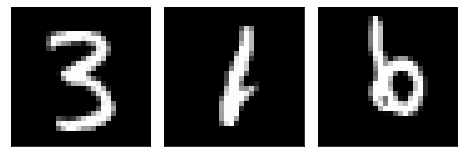

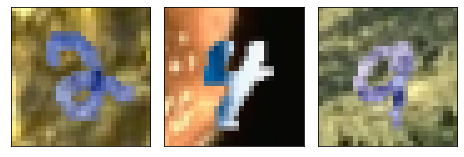

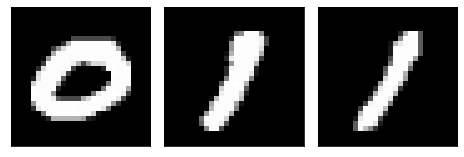

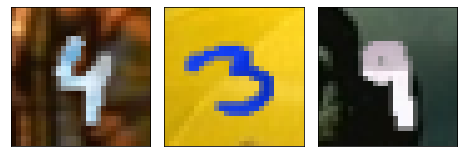

In [14]:
## Showing first n images of the dataset
dataset_first_n(ds_source_train, 3, cmap='gray')
dataset_first_n(ds_target_train, 3)
dataset_first_n(ds_source_val, 3, cmap='gray')
dataset_first_n(ds_target_val, 3)

## Model

Our model will consist of three parts, as in the figure:

* A "deep" CNN for image feature extraction (2x Conv, ReLU, MaxPool)
* A digit-classification head (3x FC, ReLU)
* A domain classification head (2x FC, ReLU), with gradient reversal layer (GRL)

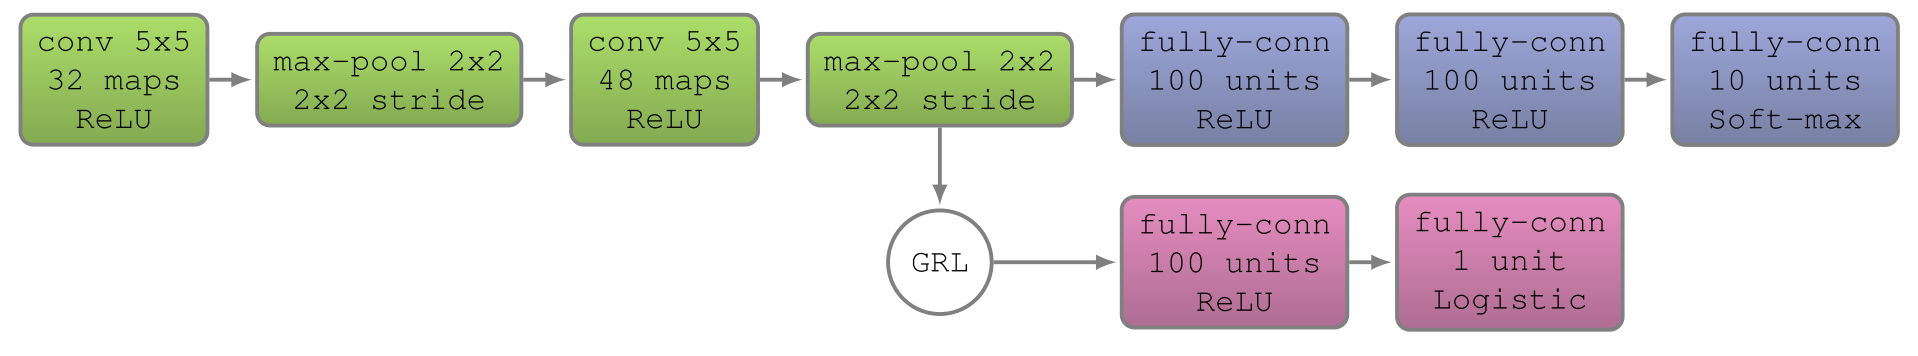

Recall: GRL is no-op in forward pass, but applies  −𝜆  factor to gradient in the backward pass.

### GRL Layer Implementation

In [15]:
from torch.autograd import Function

# Autograd Function objects are what record operation history on tensors,
# and define formulas for the forward and backprop.

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        # Store context for backprop
        ctx.alpha = alpha
        
        # Forward pass is a no-op
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass is just to -alpha the gradient
        output = grad_output.neg() * ctx.alpha

        # Must return same number as inputs to forward()
        return output, None

### Domain Adaptation CNN Model

In [16]:

class DACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5), # input - 3x28x28, output - 64x24x24
            nn.BatchNorm2d(64), nn.MaxPool2d(2), # input - 64x24x24, output - 64x12x12
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5), # input - 64x12x12, output - 50x8x8
            nn.BatchNorm2d(50), nn.Dropout(0.05), nn.MaxPool2d(2), # input - 50x8x8, output - 50x4x4
            nn.ReLU(True),
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100), nn.Dropout(0.05), # FC1
            nn.ReLU(True),
            nn.Linear(100, 100), nn.BatchNorm1d(100),# FC2
            nn.ReLU(True),
            nn.Linear(100, 10),# FC3
            nn.LogSoftmax(dim=1),
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100), # FC1
            nn.ReLU(True),
            nn.Linear(100, 2),# FC2
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x, grl_lambda=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, image_size, image_size)
        
        features = self.feature_extractor(x)
        features = features.view(-1, 50 * 4 * 4)
        reverse_features = GradientReversalFn.apply(features, grl_lambda)
        
        class_pred = self.class_classifier(features)
        domain_pred = self.domain_classifier(reverse_features)
        return class_pred, domain_pred

Wait, but why let $\lambda$ (`grl_lambda` in the code) change during training (e.g. every epoch)?

- In the beginning of training, the domain loss is extremely noisy since the CNN features are not good yet.
- Therefore, lambda is gradualy changed from 0 to 1 in the course of training.
    $$
    \lambda_p = \frac{2}{1+\exp(-10\cdot p)} -1,
    $$
    where $p\in[0,1]$ is the training progress.

In [17]:
model = DACNN()
model

DACNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 50, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
  )
  (class_classifier): Sequential(
    (0): Linear(in_features=800, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [19]:
!pip install torchinfo 
from torchinfo import summary

temp_model = DACNN().to(device)
batch_size = 2
summary(temp_model, input_size=(batch_size, 3, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
DACNN                                    [2, 10]                   --
├─Sequential: 1-1                        [2, 50, 4, 4]             --
│    └─Conv2d: 2-1                       [2, 64, 24, 24]           4,864
│    └─BatchNorm2d: 2-2                  [2, 64, 24, 24]           128
│    └─MaxPool2d: 2-3                    [2, 64, 12, 12]           --
│    └─ReLU: 2-4                         [2, 64, 12, 12]           --
│    └─Conv2d: 2-5                       [2, 50, 8, 8]             80,050
│    └─BatchNorm2d: 2-6                  [2, 50, 8, 8]             100
│    └─Dropout: 2-7                      [2, 50, 8, 8]             --
│    └─MaxPool2d: 2-8                    [2, 50, 4, 4]             --
│    └─ReLU: 2-9                         [2, 50, 4, 4]             --
├─Sequential: 1-2                        [2, 10]                   --
│    └─Linear: 2-10                      [2, 100]                  80,100
│ 

#### Checking if the model, dataloader etc. are working by sending data to untrained model

In [20]:
x0_s_train, y0_s_train = next(iter(dl_source_train))
x0_t_train, y0_t_train = next(iter(dl_target_train))


print('source domain: ', x0_s_train.shape, y0_s_train.shape)
print('target domain: ', x0_t_train.shape, y0_t_train.shape)

print(model(x0_s_train))
print(model(x0_t_train))

source domain:  torch.Size([4, 1, 28, 28]) torch.Size([4])
target domain:  torch.Size([4, 3, 28, 28]) torch.Size([4])
(tensor([[-2.5755, -2.8922, -2.4209, -1.8227, -2.5879, -2.4812, -2.1835, -2.0479,
         -2.3535, -2.0998],
        [-2.0638, -2.2549, -1.7310, -2.2257, -2.5133, -3.1658, -2.1830, -3.1324,
         -2.7214, -1.9822],
        [-2.4014, -3.0739, -1.9253, -2.1120, -1.8265, -2.5142, -2.3912, -2.5831,
         -2.4929, -2.2565],
        [-2.0852, -2.2540, -2.0639, -1.6940, -2.3330, -2.7002, -3.2502, -2.3277,
         -2.7799, -2.3282]], grad_fn=<LogSoftmaxBackward0>), tensor([[-0.2468, -1.5199],
        [-0.8558, -0.5533],
        [-0.4850, -0.9563],
        [-0.4240, -1.0625]], grad_fn=<LogSoftmaxBackward0>))
(tensor([[-2.8744, -2.2893, -1.7131, -2.1906, -1.8203, -3.0864, -2.8537, -2.9638,
         -2.6745, -1.8066],
        [-1.9478, -2.9397, -1.8675, -2.1557, -2.4036, -2.9488, -2.3194, -2.3121,
         -2.6429, -2.0966],
        [-2.0145, -2.4031, -2.6113, -1.4884, -2.

### Source Training *Function*

In [21]:
### Source Training Function
from tqdm import tqdm # for beautiful model training updates

def train_model(model, device, train_loader,optimizer,epoch):
    model.train() # setting the model in training mode
    pbar = tqdm(train_loader) # putting the iterator in pbara
    correct = 0 # for accuracy numerator
    processed =0 # for accuracy denominator

    for batch_idx, batch in enumerate(pbar):

        X_s, y_s = batch[0].to(device), batch[1].long().to(device) 
        #sending data to CPU or GPU as per device
        optimizer.zero_grad() # setting gradients to zero to avoid accumulation

        class_pred, _ = model(X_s, grl_lambda = 0)
        loss = F.nll_loss(class_pred, y_s) # capturing loss
        # forward pass, result captured in y_preds (plural as there are many body in a batch)
        # we are not interested in domain prediction
        # the predictions are in one hot vector
        
        loss.backward() # backpropagation
        optimizer.step() # updating the params

        preds = class_pred.argmax(dim=1, keepdim=True)  # get the index olf the max log-probability
        correct += preds.eq(y_s.view_as(preds)).sum().item()

        processed += len(X_s)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


### Typical Test Function

In [22]:
## This is same as DANN test function

### DANN Training *Function*

In [23]:
# DANN Training Function

def dann_train_model(model, device, train_source_loader, train_target_loader,optimizer, epoch, num_epochs):
    model.train() # setting the model in training mode
    # understanding batch size by understanding length of two dataloaders
    len_dataloader = min(len(train_source_loader), len(train_target_loader)) # training for minimum of two dataloaders

    i = 0 # as the training progresses the alpha changes
    while i < len_dataloader -1:
        # implementation of alpha as per paper
        p = float(i + epoch * len_dataloader) / (num_epochs * len_dataloader)
        grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1

        # Train on source domain
        X_s, y_s = next(iter(train_source_loader))
        X_s, y_s = X_s.to(device), y_s.to(device)
        y_s_domain = torch.zeros(batch_size, dtype=torch.long).to(device) # generate source domain labels

        class_pred, domain_pred = model(X_s, grl_lambda)
        loss_s_label = F.nll_loss(class_pred, y_s)
        loss_s_domain = F.nll_loss(domain_pred, y_s_domain)

        # Train on target domain
        X_t, _ = next(iter(train_target_loader)) # ignore target domain class labels!
        X_t = X_t.to(device)
        y_t_domain = torch.ones(batch_size, dtype=torch.long).to(device) # generate target domain labels

        _, domain_pred = model(X_t, grl_lambda) # ignore the model output in terms of class labels
        loss_t_domain = F.nll_loss(domain_pred, y_t_domain)
        
        loss = loss_t_domain + loss_s_domain + loss_s_label
        loss.backward()
        optimizer.step()

        if ((i + 1) % 10 == 0):
          print(f'[{i+1}/{len_dataloader}] '
                f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
                f't_domain_loss: {loss_t_domain.item():.4f} ' f'grl_lambda: {grl_lambda:.3f} '
              )
        
        i = i+1

### DANN Test *Function*

In [24]:
# DANN Test Function

def dann_test_model(model, device, test_loader):
    model.eval() # setting the model in evaluation mode
    grl_lambda = 0
    test_loss = 0
    correct = 0  # for accuracy numerator

    with torch.no_grad():
        for (X_t,y_t) in test_loader:
            
            X_t, y_t = X_t.to(device), y_t.long().to(device) #sending data to CPU or GPU as per device
            class_outputs, _  = model(X_t, grl_lambda = grl_lambda) # forward pass, plural results
            
            test_loss = F.nll_loss(class_outputs, y_t, reduction='sum').item()  # sum up batch loss
            preds = class_outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += preds.eq(y_t.view_as(preds)).sum().item()
        
        test_loss /= len(test_loader.dataset) # average test loss

            
        print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%) \n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

### Test and Training Declarations

In [25]:
lr = 1e-3
n_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Setup optimizer as usual

typical_model = DACNN()
typical_model = typical_model.to(device)
optimizer = optim.Adam(typical_model.parameters(), lr)

dann_model = DACNN()
dann_model = dann_model.to(device)
optimizer_dann = optim.Adam(dann_model.parameters(), lr) # note the change in optimizer



batch_size = 2048

dl_source_train = torch.utils.data.DataLoader(ds_source_train, batch_size)
dl_source_val = torch.utils.data.DataLoader(ds_source_val, batch_size)
dl_target_train = torch.utils.data.DataLoader(ds_target_train, batch_size)
dl_target_val = torch.utils.data.DataLoader(ds_target_val, batch_size)


cuda


### Typical Model Training and Testing Loop

In [26]:
## Typical model
for epoch in range(n_epochs):
    print("EPOCH:", epoch+1)
    train_model(typical_model, device, dl_source_train, optimizer, epoch)
    print('\nTesting on Source Val......')
    dann_test_model(typical_model, device, dl_source_val)
    print('\nTesting on Target Val......')
    dann_test_model(typical_model, device, dl_target_val)
print("Typical model training and validation completed")

EPOCH: 1


Loss=0.297707200050354 Batch_id=29 Accuracy=86.68: 100%|██████████| 30/30 [00:26<00:00,  1.11it/s]



Testing on Source Val......
Test set: Average loss: 0.0563, Accuracy: 9703/10000 (97.03%) 


Testing on Target Val......
Test set: Average loss: 0.2398, Accuracy: 1283/9001 (14.25%) 

EPOCH: 2


Loss=0.12551377713680267 Batch_id=29 Accuracy=97.52: 100%|██████████| 30/30 [00:18<00:00,  1.62it/s]



Testing on Source Val......
Test set: Average loss: 0.0228, Accuracy: 9814/10000 (98.14%) 


Testing on Target Val......
Test set: Average loss: 0.2890, Accuracy: 1195/9001 (13.28%) 

EPOCH: 3


Loss=0.07851839065551758 Batch_id=29 Accuracy=98.55: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s]



Testing on Source Val......
Test set: Average loss: 0.0131, Accuracy: 9863/10000 (98.63%) 


Testing on Target Val......
Test set: Average loss: 0.3183, Accuracy: 1210/9001 (13.44%) 

EPOCH: 4


Loss=0.05484168231487274 Batch_id=29 Accuracy=99.03: 100%|██████████| 30/30 [00:20<00:00,  1.45it/s]



Testing on Source Val......
Test set: Average loss: 0.0085, Accuracy: 9893/10000 (98.93%) 


Testing on Target Val......
Test set: Average loss: 0.3400, Accuracy: 1212/9001 (13.47%) 

EPOCH: 5


Loss=0.03501274436712265 Batch_id=29 Accuracy=99.32: 100%|██████████| 30/30 [00:19<00:00,  1.57it/s]



Testing on Source Val......
Test set: Average loss: 0.0068, Accuracy: 9897/10000 (98.97%) 


Testing on Target Val......
Test set: Average loss: 0.3712, Accuracy: 1199/9001 (13.32%) 

Typical model training and validation completed


### DANN Training and Testing Loop

In [27]:
### DANN
for epoch in range(n_epochs):
    print("EPOCH:", epoch+1)
    dann_train_model(dann_model, device, dl_source_train, dl_target_train, optimizer_dann, epoch, num_epochs = n_epochs)
    print('Testing on Source Val......')
    dann_test_model(dann_model, device, dl_source_val)
    print('Testing on Target Val......')
    dann_test_model(dann_model, device, dl_target_val)
print("DANN model training and validtion completed")

EPOCH: 1
[10/29] class_loss: 1.0309 s_domain_loss: 0.7124 t_domain_loss: 0.7107 grl_lambda: 0.301 
[20/29] class_loss: 0.6309 s_domain_loss: 0.7387 t_domain_loss: 0.6709 grl_lambda: 0.575 
Testing on Source Val......
Test set: Average loss: 0.1599, Accuracy: 7021/10000 (70.21%) 

Testing on Target Val......
Test set: Average loss: 0.2001, Accuracy: 2263/9001 (25.14%) 

EPOCH: 2
[10/29] class_loss: 0.3182 s_domain_loss: 0.7115 t_domain_loss: 0.7886 grl_lambda: 0.864 
[20/29] class_loss: 0.2151 s_domain_loss: 0.5589 t_domain_loss: 0.8752 grl_lambda: 0.930 
Testing on Source Val......
Test set: Average loss: 0.0899, Accuracy: 8016/10000 (80.16%) 

Testing on Target Val......
Test set: Average loss: 0.3100, Accuracy: 1601/9001 (17.79%) 

EPOCH: 3
[10/29] class_loss: 0.1554 s_domain_loss: 0.6443 t_domain_loss: 0.8497 grl_lambda: 0.980 
[20/29] class_loss: 0.1259 s_domain_loss: 0.8775 t_domain_loss: 0.6189 grl_lambda: 0.990 
Testing on Source Val......
Test set: Average loss: 0.1799, Accurac

### Confusion Metrics, Accuracy, Precision, Recall, F1

In [28]:


# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =",device)


classes = ('0','1','2','3','4','5','6','7','8','9')

dict_testloader = {"Source Val": dl_source_val,"Target Val":dl_target_val}
dict_model = {"Typical": typical_model,"DANN": dann_model}


device = cuda


------------Model = Typical, Domain Validation = Source Val---------
confusion matrix 
      0     1     2     3    4    5    6     7    8    9
0  974     1     0     0    0    0    2     2    1    0
1    0  1135     0     0    0    0    0     0    0    0
2    1     3  1020     1    1    0    1     4    1    0
3    0     0     2  1003    0    2    0     2    1    0
4    0     0     1     0  975    0    2     0    1    3
5    0     0     0     4    0  886    1     1    0    0
6    3     4     0     0    1    4  946     0    0    0
7    0     3     4     0    0    0    0  1021    0    0
8    2     1     2     2    1    3    1     4  958    0
9    0     2     0     4    9    2    0    10    3  979
 Accuracy = 0.9897 
Precision = [0.99387755 0.98781549 0.99125364 0.98915187 0.98784195 0.9877369
 0.99265477 0.97796935 0.99274611 0.99694501] 
 Recall = [0.99387755 1.         0.98837209 0.99306931 0.99287169 0.99327354
 0.9874739  0.99319066 0.9835729  0.97026759] 
f1 = [0.99387755 0.9938704 

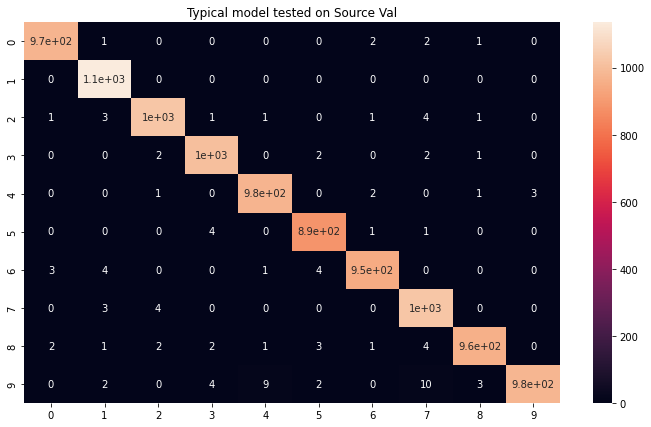

------------Model = Typical, Domain Validation = Target Val---------
confusion matrix 
     0     1  2  3  4   5  6   7  8  9
0  67   808  0  0  0   2  0   1  0  0
1   0  1016  0  0  0   0  0   0  0  0
2   0   930  2  0  0   0  0   1  0  0
3   3   899  0  3  0   1  0   2  0  0
4   0   890  0  0  0   0  0   0  0  0
5   2   746  0  0  0  59  0   0  0  0
6   1   850  0  0  0   1  4   0  0  0
7   0   866  0  0  0   0  0  48  0  0
8   2   877  0  0  0   0  0   1  0  0
9   2   904  0  0  0   0  0  13  0  0
 Accuracy = 0.13320742139762248 
Precision = [0.87012987 0.11563852 1.         1.         0.         0.93650794
 1.         0.72727273 0.         0.        ] 
 Recall = [0.07630979 1.         0.00214362 0.00330396 0.         0.07311029
 0.0046729  0.05251641 0.         0.        ] 
f1 = [0.14031414 0.20730463 0.00427807 0.00658617 0.         0.13563218
 0.00930233 0.09795918 0.         0.        ]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


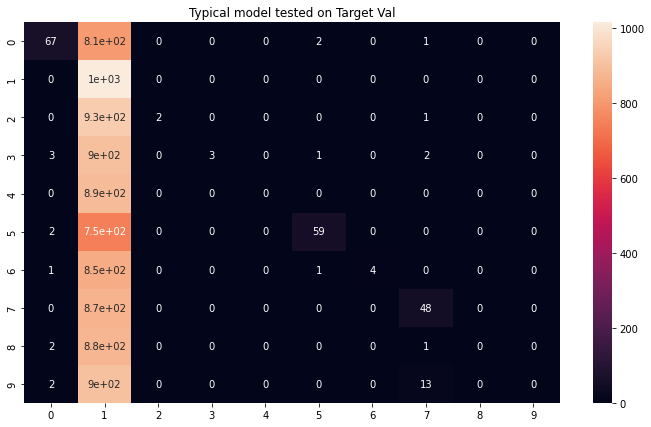

------------Model = DANN, Domain Validation = Source Val---------
confusion matrix 
      0    1    2    3    4    5    6    7    8    9
0  956    0    0    2    3    0    3    1   10    5
1    0  893   25   32    1    0    6  135   42    1
2    1    0  934   48    7    0    2    7   32    1
3    0    0    3  993    0    0    0    2    6    6
4    1    0    0    6  913    0    7    0    5   50
5   10    0    0   63    0  710    3    0   96   10
6    6    0    1    0    9    2  923    0   17    0
7    4    0   31   38    0    0    0  822    6  127
8    1    0    4   12    0    0    0    2  949    6
9    3    0    0    7    4    4    1    4   15  971
 Accuracy = 0.9064 
Precision = [0.97352342 1.         0.93587174 0.82681099 0.97438634 0.99162011
 0.97671958 0.84480987 0.80560272 0.82497876] 
 Recall = [0.9755102  0.78678414 0.90503876 0.98316832 0.92973523 0.79596413
 0.96346555 0.79961089 0.97433265 0.96233895] 
f1 = [0.9745158  0.88067061 0.92019704 0.89823609 0.95153726 0.88308458
 

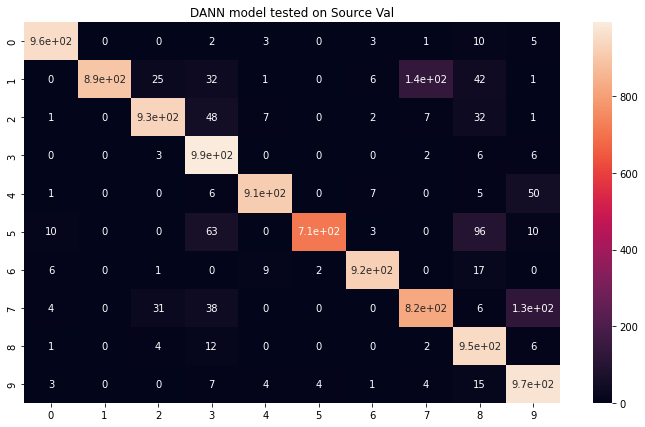

------------Model = DANN, Domain Validation = Target Val---------
confusion matrix 
     0    1    2    3    4    5    6    7   8    9
0  82  536   83    8    1   41   88   37   1    1
1   3  780  195    2    2    5   15   14   0    0
2   3  553  306   12    2    9    6   34   7    1
3   0  515   33  260    4   41    8   42   5    0
4   2  633   44   21  132   24   11   21   1    1
5   0  405    8   22    0  352    9    6   4    1
6   4  536   18   10    1   22  264    1   0    0
7   1  533   58    8    1   20    8  277   4    4
8   0  572  142    9    2   35   27   45  44    4
9   3  585   16   17   29   59    1   84   6  119
 Accuracy = 0.29063437395844904 
Precision = [0.83673469 0.13810198 0.33887043 0.70460705 0.75862069 0.57894737
 0.60411899 0.49376114 0.61111111 0.90839695] 
 Recall = [0.09339408 0.76771654 0.32797428 0.28634361 0.14831461 0.4361834
 0.30841121 0.30306346 0.05       0.12948857] 
f1 = [0.16803279 0.23409364 0.33333333 0.40720439 0.2481203  0.4975265
 0.40835267 

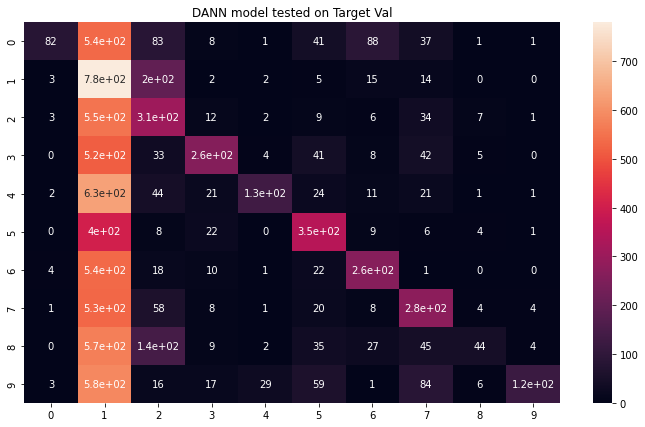

In [29]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score,f1_score,accuracy_score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


for model_name, model in dict_model.items():
  model.eval()  # setting the model into evaluation mode
  grl_lambda = 0
  for domain_name, test_loader  in dict_testloader.items():
    y_pred = []
    y_true = []

    for (X_t,y_t) in test_loader:
      X_t, y_t = X_t.to(device), y_t.long().to(device) #sending data to CPU or GPU as per device

      # Ground Truth Values
      truths = y_t.tolist()
      # truths = y_t.cpu().numpy() # CPU
      y_true.extend(truths) # Save Truth

      # Prediction Values
      class_outputs, _  = model(X_t, grl_lambda = grl_lambda) # forward pass, plural results
      preds = (torch.max(torch.exp(class_outputs), 1)[1]).tolist()

      # print(preds)
      # preds = class_outputs.argmax(dim=1, keepdim=True).data.cpu().numpy()  # CPU
      y_pred.extend(preds) # Save Predicted
      
    # Build confusion matrix
    print(f'------------Model = {model_name}, Domain Validation = {domain_name}---------')
    cf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score (y_true, y_pred, average=None)
    f1 = f1_score (y_true, y_pred, average=None)

    df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                         columns = [i for i in classes])
    print("confusion matrix \n",df_cm)
    print (f' Accuracy = {accuracy} \nPrecision = {precision} \n Recall = {recall} \nf1 = {f1}')
    plt.figure(figsize = (12,7))
    ax = plt.axes()
    sn.heatmap(df_cm, ax= ax, annot=True)

    ax.set_title(model_name+" model tested on "+domain_name)
    plt.show()
    # sn.heatmap(df_cm, annot=True)
      
